<a href="https://colab.research.google.com/github/ivanpalenciab/Prediccion-atlantico/blob/modelado-tres-modos/3_red_neuronal_densa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

#modulos sklearn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler


#modulos keras
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.optimizers import  RMSprop

In [3]:
modo_1 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/emd_modes/Modo_1.csv")
modo_2 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/emd_modes/Modo_2.csv")
residuo = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/emd_modes/Residuo.csv")
modo_1["FECHA"] = pd.to_datetime(modo_1["FECHA"],format='%Y-%m-%d')
modo_2["FECHA"] = pd.to_datetime(modo_2["FECHA"],format='%Y-%m-%d')
residuo["FECHA"] = pd.to_datetime(residuo["FECHA"],format='%Y-%m-%d')
modo_1.set_index("FECHA", inplace=True)
modo_2.set_index("FECHA", inplace=True)
residuo.set_index("FECHA", inplace=True)

<Axes: xlabel='FECHA'>

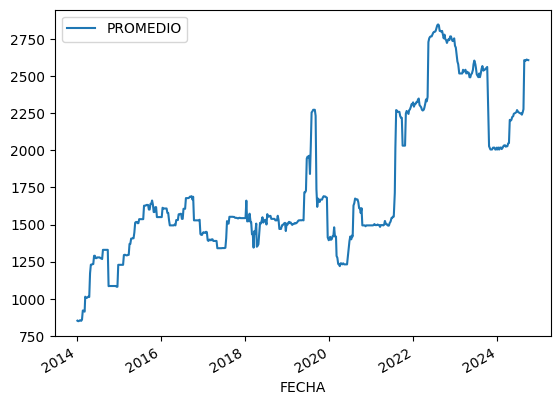

In [4]:
datos_emd =modo_1 + modo_2 + residuo
datos_emd.plot()

In [5]:
datos_emd.describe()

,PROMEDIO
count,554.000000
mean,1746.012635
std,484.698883
min,848.000000
25%,1448.000000
50%,1543.000000
75%,2162.500000
max,2850.000000


In [6]:
#agregar características de retraso al conjunto de datos
def add_lags(df,pasos):
    target_map = df['PROMEDIO'].to_dict()
    for i in range(pasos+1):
      df[f'retraso-{i}'] = df['PROMEDIO'].shift(i)
    df = df.drop(columns=["retraso-0"])
    df.dropna(inplace=True)
    return df

In [ ]:
def crear_modelo_densa(PASOS, num_capas, lista_neuronas):
    modelo = Sequential()
    # Añadir la primera capa densa con input_shape definido
    modelo.add(Dense(units=lista_neuronas[0], input_shape=(1, PASOS), activation='tanh'))

    # Añadir capas ocultas adicionales si num_capas > 1
    for i in range(1, num_capas):
        modelo.add(Dense(units=lista_neuronas[i], activation='tanh'))

    # Añadir capa Flatten si es necesario
    modelo.add(Flatten())

    # Añadir la capa de salida
    modelo.add(Dense(units=1))

    # Compilar el modelo
    modelo.compile(optimizer=RMSprop(learning_rate=0.0083), loss='mse')
    return modelo

In [57]:
def probar_modelos_densa(PASOS, lista_capas, lista_neuronas, X_train, y_train, X_val, y_val):
    resultados = {}
    for num_capas in lista_capas:
        # Generar combinaciones de neuronas para las capas
        combinaciones_neuronas = generar_combinaciones_neuronas(num_capas, lista_neuronas)
        for combo_neuronas in combinaciones_neuronas:
            print(f"Entrenando modelo con {num_capas} capas y neuronas por capa: {combo_neuronas}")
            modelo = crear_modelo_densa(PASOS, num_capas, combo_neuronas)
            historia = modelo.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=0)
            perdida_val = historia.history['val_loss'][-1]
            resultados[(num_capas, tuple(combo_neuronas))] = perdida_val
            print(f"Pérdida de validación: {perdida_val}")
    return resultados

def generar_combinaciones_neuronas(num_capas, lista_neuronas):
    # Generar todas las combinaciones posibles de neuronas para un número dado de capas
    from itertools import product
    return list(product(lista_neuronas, repeat=num_capas))

In [7]:
# de pasos que vamos a utilizar para convertir nuestra serie de tiempo a aprendizaje supervizado
PASOS = 7

# Modelamos Modo 1

In [8]:
modo_1_values = modo_1.values
modo_1_values = modo_1_values.astype('float32')
modo_1_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_1_values = modo_1_values.reshape(-1, 1)
modo_1_escalado =  pd.DataFrame(modo_1_scaler.fit_transform(modo_1_values), columns=modo_1.columns,index=modo_1.index)
modo_1_sup = add_lags(modo_1_escalado, PASOS)
modo_1_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632,0.008232,0.010940
2014-02-26,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632,0.008232
2014-03-07,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632
2014-03-12,0.158988,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825
2014-03-19,-0.025976,0.158988,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434


In [9]:
total_datos=len(modo_1_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m1 = modo_1_sup[:division_entrenamiento]
datos_validacion_m1 = modo_1_sup[division_entrenamiento:division_validacion]
datos_testeo_m1 = modo_1_sup[division_validacion:total_datos]

datos_entrenamiento_m1_values= datos_entrenamiento_m1.values
datos_validacion_m1_values = datos_validacion_m1.values
datos_testeo_m1_values = datos_testeo_m1.values

X_train, y_train = datos_entrenamiento_m1_values[:, :-1], datos_entrenamiento_m1_values[:, -1]
X_val, y_val = datos_validacion_m1_values[:, :-1], datos_validacion_m1_values[:, -1]
X_test, y_test = datos_testeo_m1_values[:, :-1], datos_testeo_m1_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(437, 1, 7) (437,) (54, 1, 7) (54,) (56, 1, 7) (56,)


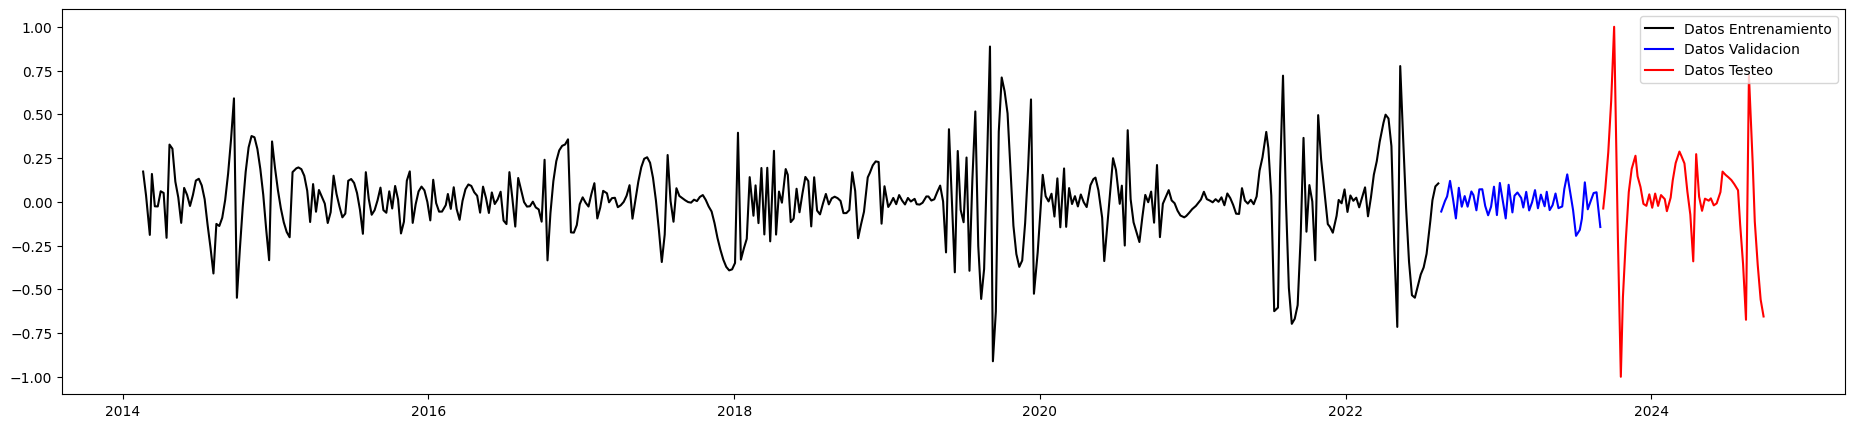

In [10]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m1.index,datos_validacion_m1.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [13]:
def modeloRD_m1():
  modelo = Sequential()
  modelo.add(Dense(units=47, input_shape=(1,PASOS), activation='tanh'))
  modelo.add(Dense(units=28,  activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.0083), loss='mse')
  return modelo

In [17]:
modelo = modeloRD_m1()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0793
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0497
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0647
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0462
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0434
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0452
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0498
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0541
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0456
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0467
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0429
Epoch 12/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0477
Epoch 13/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0409
Epoch 14/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0447
Epoch 15/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0448
Epoch 16/40
63/63 ━

In [18]:
prediccion_validacion_m1 = modelo.predict(X_val)
prediccion_testeo_m1 = modelo.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


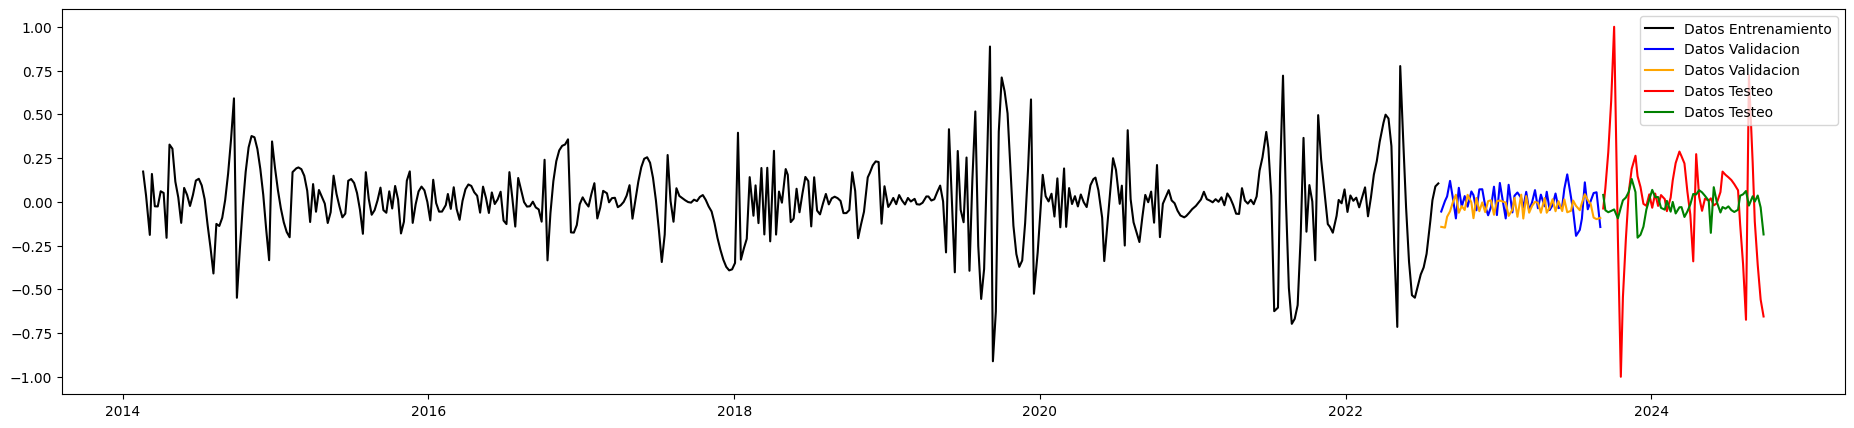

In [19]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m1.index,datos_validacion_m1.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m1.index,prediccion_validacion_m1,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m1.index,prediccion_testeo_m1,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [20]:
datos_validacion_m1

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2022-08-17,-0.055714,0.104793,0.087837,0.009289,-0.107953,-0.297173,-0.375279,-0.415655
2022-08-26,0.004814,-0.055714,0.104793,0.087837,0.009289,-0.107953,-0.297173,-0.375279
2022-08-31,0.030425,0.004814,-0.055714,0.104793,0.087837,0.009289,-0.107953,-0.297173
2022-09-07,0.119458,0.030425,0.004814,-0.055714,0.104793,0.087837,0.009289,-0.107953
2022-09-14,0.017962,0.119458,0.030425,0.004814,-0.055714,0.104793,0.087837,0.009289
2022-09-21,-0.095035,0.017962,0.119458,0.030425,0.004814,-0.055714,0.104793,0.087837
2022-09-28,0.079835,-0.095035,0.017962,0.119458,0.030425,0.004814,-0.055714,0.104793
2022-10-05,-0.028180,0.079835,-0.095035,0.017962,0.119458,0.030425,0.004814,-0.055714
2022-10-12,0.032536,-0.028180,0.079835,-0.095035,0.017962,0.119458,0.030425,0.004814


In [21]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m1,datos_validacion_m1.PROMEDIO))
print(score)

0.09603951


In [22]:
prediccion_validacion_m1 = modo_1_scaler.inverse_transform(prediccion_validacion_m1)
prediccion_testeo_m1 = modo_1_scaler.inverse_transform(prediccion_testeo_m1 )

# Modelamos modo 2

In [23]:
modo_2_values = modo_2.values
modo_2_values = modo_2_values.astype('float32')
modo_2_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_2_values = modo_2_values.reshape(-1, 1)
modo_2_escalado =  pd.DataFrame(modo_2_scaler.fit_transform(modo_2_values), columns=modo_2.columns,index=modo_2.index)
modo_2_sup = add_lags(modo_2_escalado, PASOS)
modo_2_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002,-0.125543,-0.115907
2014-02-26,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002,-0.125543
2014-03-07,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002
2014-03-12,0.090317,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698
2014-03-19,0.108054,0.090317,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053


In [24]:
total_datos=len(modo_2_sup)
#modo_4_sup = modo_4_sup.values
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m2 = modo_2_sup[:division_entrenamiento]
datos_validacion_m2 = modo_2_sup[division_entrenamiento:division_validacion]
datos_testeo_m2 = modo_2_sup[division_validacion:total_datos]

datos_entrenamiento_m2_values= datos_entrenamiento_m2.values
datos_validacion_m2_values = datos_validacion_m2.values
datos_testeo_m2_values = datos_testeo_m2.values

X_train, y_train = datos_entrenamiento_m2_values[:, :-1], datos_entrenamiento_m2_values[:, -1]
X_val, y_val = datos_validacion_m2_values[:, :-1], datos_validacion_m2_values[:, -1]
X_test, y_test = datos_testeo_m2_values[:, :-1], datos_testeo_m2_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(437, 1, 7) (437,) (54, 1, 7) (54,) (56, 1, 7) (56,)


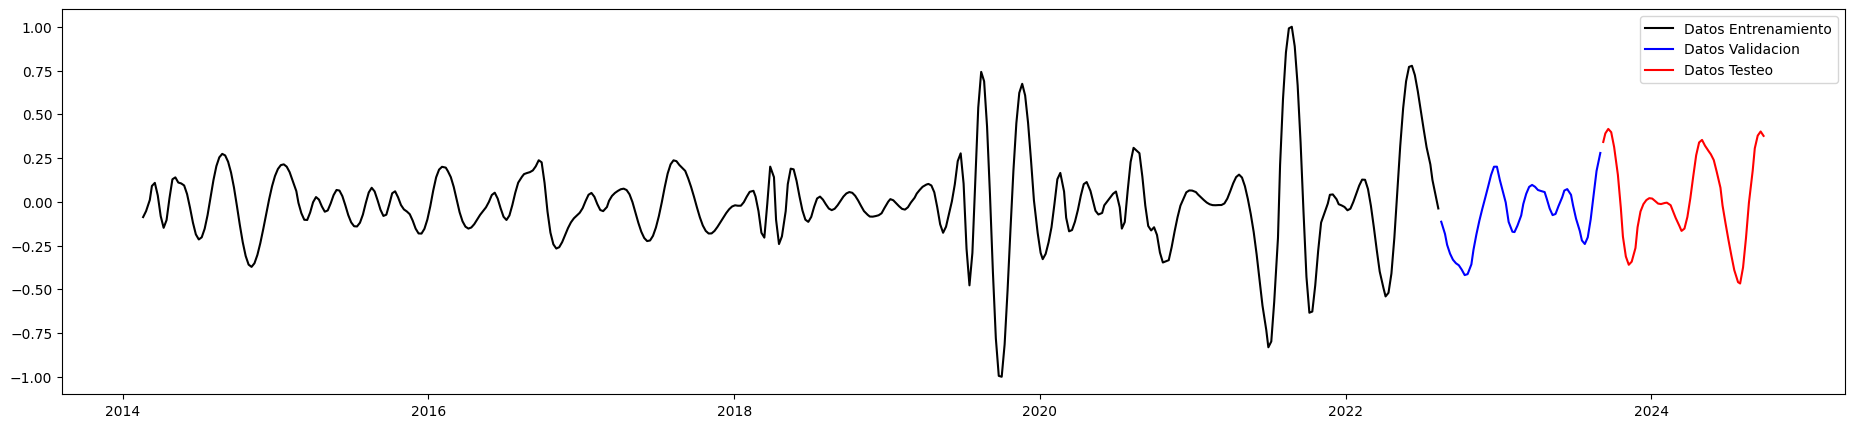

In [25]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m2.index,datos_validacion_m2.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [26]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [27]:
def modeloRD_m2():
  modelo = Sequential()
  modelo.add(Dense(units=46, input_shape=(1,PASOS), activation='tanh'))
  modelo.add(Dense(units=63,  activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.0037), loss='mse')
  return modelo


In [28]:
modelo = modeloRD_m2()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0416
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028
Epoch 12/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028
Epoch 13/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026
Epoch 14/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027
Epoch 15/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030
Epoch 16/40
63/63 ━━━━━━━━━━━━

In [29]:
prediccion_validacion_m2 = modelo.predict(X_val)
prediccion_testeo_m2 = modelo.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


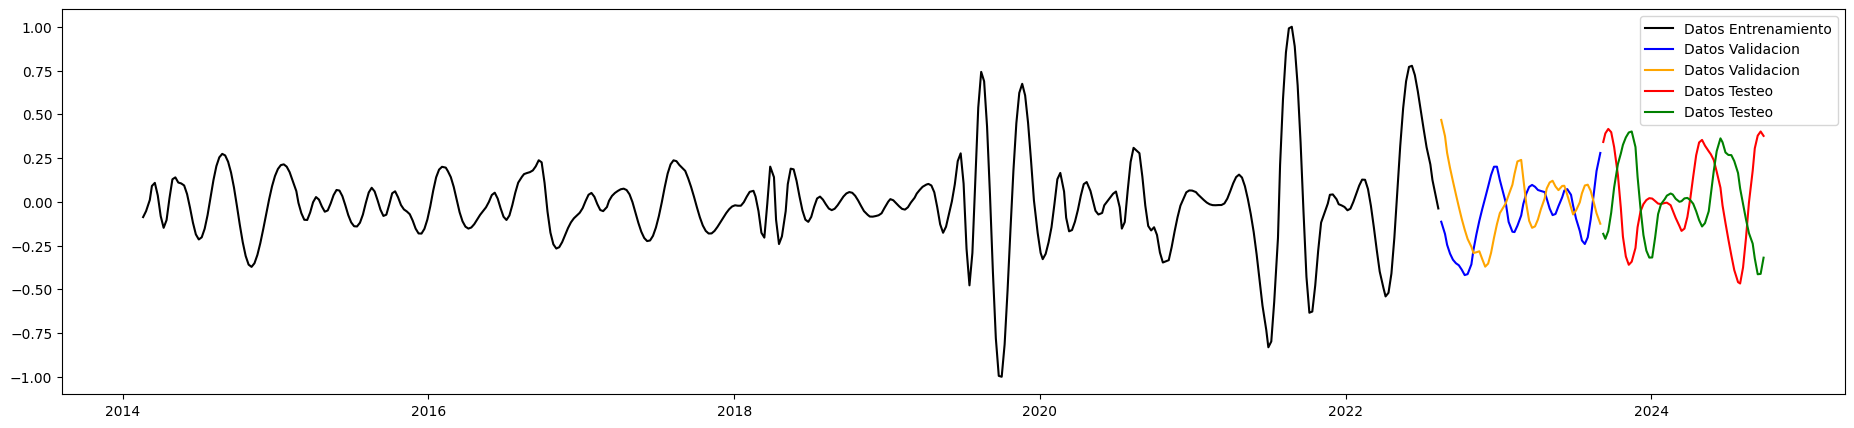

In [30]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m2.index,datos_validacion_m2.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m2.index,prediccion_validacion_m2,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m2.index,prediccion_testeo_m2,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

Esta actualmente en 0.2015

In [31]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m2,datos_validacion_m2.PROMEDIO))
print(score)

0.27667826


In [32]:
prediccion_validacion_m2 = modo_2_scaler.inverse_transform(prediccion_validacion_m2)
prediccion_testeo_m2 = modo_2_scaler.inverse_transform(prediccion_testeo_m2 )

# Modelamos Residuo

In [33]:
residuo_values = residuo.values
residuo_values = residuo_values.astype('float32')
residuo_scaler = MinMaxScaler(feature_range=(-1, 1))
residuo_values = residuo_values.reshape(-1, 1)
residuo_escalado =  pd.DataFrame(residuo_scaler.fit_transform(residuo_values), columns=residuo.columns,index=residuo.index)
residuo_sup = add_lags(residuo_escalado, PASOS)
residuo_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,-0.967619,-0.977288,-0.985017,-0.990960,-0.995275,-0.998115,-0.999638,-1.000000
2014-02-26,-0.955854,-0.967619,-0.977288,-0.985017,-0.990960,-0.995275,-0.998115,-0.999638
2014-03-07,-0.941837,-0.955854,-0.967619,-0.977288,-0.985017,-0.990960,-0.995275,-0.998115
2014-03-12,-0.925414,-0.941837,-0.955854,-0.967619,-0.977288,-0.985017,-0.990960,-0.995275
2014-03-19,-0.906428,-0.925414,-0.941837,-0.955854,-0.967619,-0.977288,-0.985017,-0.990960


In [34]:
total_datos=len(residuo_sup)

porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_residuo = residuo_sup[:division_entrenamiento]
datos_validacion_residuo = residuo_sup[division_entrenamiento:division_validacion]
datos_testeo_residuo= residuo_sup[division_validacion:total_datos]

datos_entrenamiento_residuo_values= datos_entrenamiento_residuo.values
datos_validacion_residuo_values = datos_validacion_residuo.values
datos_testeo_residuo_values = datos_testeo_residuo.values

X_train, y_train = datos_entrenamiento_residuo_values[:, :-1], datos_entrenamiento_residuo_values[:, -1]
X_val, y_val = datos_validacion_residuo_values[:, :-1], datos_validacion_residuo_values[:, -1]
X_test, y_test = datos_testeo_residuo_values[:, :-1], datos_testeo_residuo_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(437, 1, 7) (437,) (54, 1, 7) (54,) (56, 1, 7) (56,)


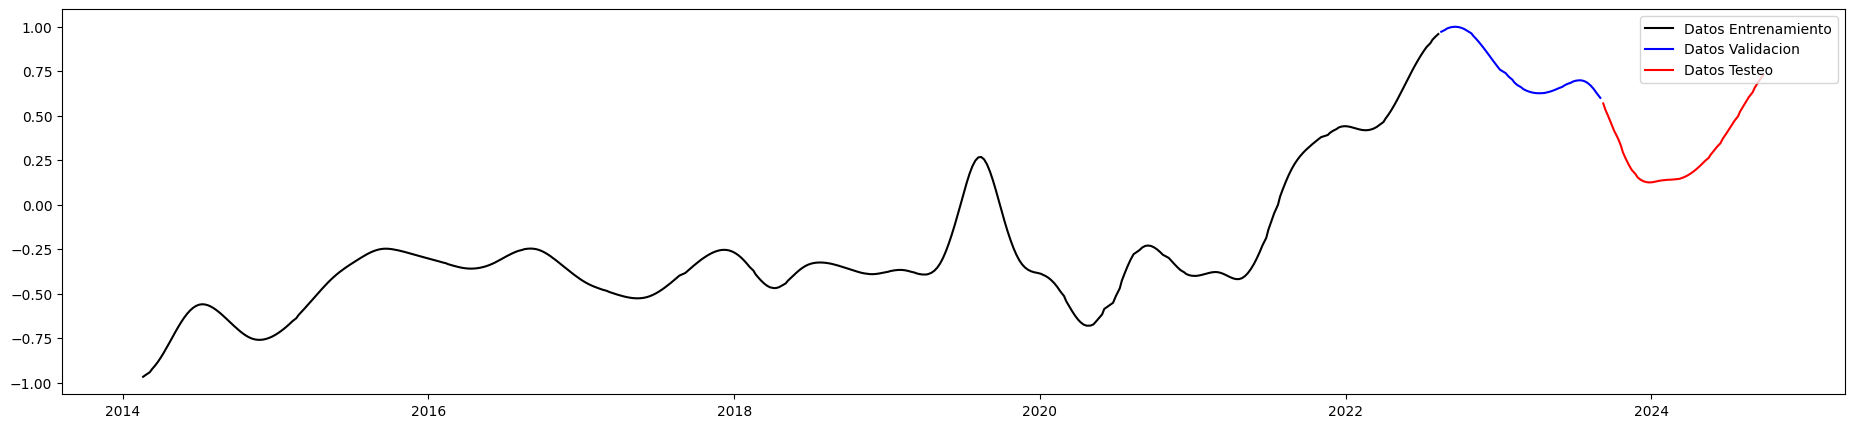

In [35]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [36]:
def modeloRD_residuo():
  modelo = Sequential()
  modelo.add(Dense(units=PASOS, input_shape=(1,PASOS), activation='tanh'))
  modelo.add(Dense(units=50, activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer='rmsprop', loss='mse')
  return modelo

In [37]:
modelo = modeloRD_residuo()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0316
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0124e-04
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.5693e-04
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.9502e-04
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6944e-04
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9139e-04
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2442e-04
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4296e-04
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3038e-04
Epoch 12/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2544e-04
Epoch 13/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5122e-04
Epoch 14/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5161e-04
Epoch 15/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

In [38]:
prediccion_validacion_residuo = modelo.predict(X_val)
prediccion_testeo_residuo = modelo.predict(X_test)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


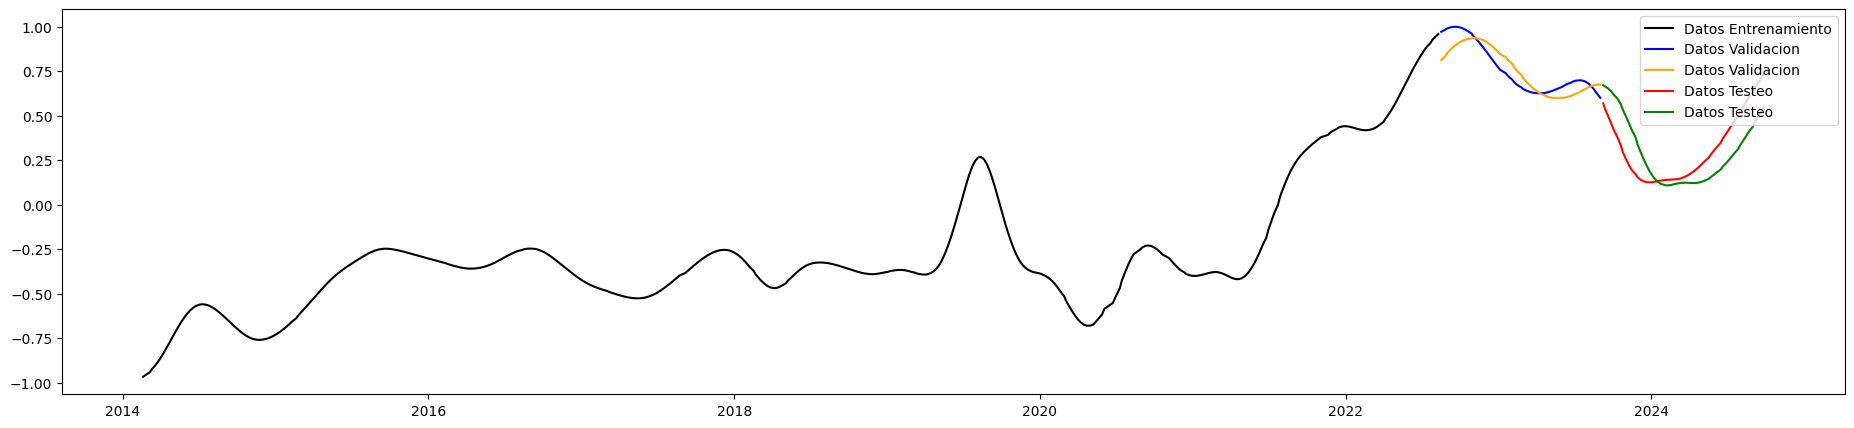

In [39]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_residuo.index,prediccion_validacion_residuo,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_residuo.index,prediccion_testeo_residuo,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

el score esta en 12.27

In [41]:
score = np.sqrt(mean_squared_error(prediccion_validacion_residuo,datos_validacion_residuo.PROMEDIO))
print(score)

0.07054559


In [42]:
prediccion_validacion_residuo = residuo_scaler.inverse_transform(prediccion_validacion_residuo)
prediccion_testeo_residuo = residuo_scaler.inverse_transform(prediccion_testeo_residuo  )

# Ensemble
vamos a hacer el ensemble de todos los modelos para obtener el modelo final

In [44]:
datos_emd
validacion = prediccion_validacion_m1 +prediccion_validacion_m2 + prediccion_validacion_residuo
testeo = prediccion_testeo_m1 +prediccion_testeo_m2 + prediccion_testeo_residuo

In [45]:
total_datos=len(datos_emd.PROMEDIO)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento = datos_emd[:division_entrenamiento]
datos_validacion = datos_emd[division_entrenamiento:division_validacion]
datos_testeo = datos_emd[division_validacion:total_datos]

In [56]:
recm_validacion = np.sqrt(mean_squared_error( validacion,datos_validacion.PROMEDIO[:-1]))
eam_validacion = mean_absolute_error( validacion,datos_validacion.PROMEDIO[:-1])
EPAM_validacion = mean_absolute_percentage_error( validacion,datos_validacion.PROMEDIO[:-1])


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm_validacion} ' )
print ( f'el error absoluto medio del modelo es: {eam_validacion} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM_validacion} o {round(EPAM_validacion,2)}%")

La raiz del error cuadratico medio del modelo es: 64.80095039535495 
el error absoluto medio del modelo es: 48.27520073784669 
Error porcentual absoluto medio del modelo es: 0.018543153127526062 o 0.02%


In [54]:
recm = np.sqrt(mean_squared_error( testeo,datos_testeo.PROMEDIO))
eam = mean_absolute_error( testeo,datos_testeo.PROMEDIO)
EPAM = mean_absolute_percentage_error(testeo,datos_testeo.PROMEDIO)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm} ' )
print ( f'el error absoluto medio del modelo es: {eam} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM} o {round(EPAM,2)}%")

La raiz del error cuadratico medio del modelo es: 211.54829386049718 
el error absoluto medio del modelo es: 148.20006888253354 
Error porcentual absoluto medio del modelo es: 0.06564939223826666 o 0.07%


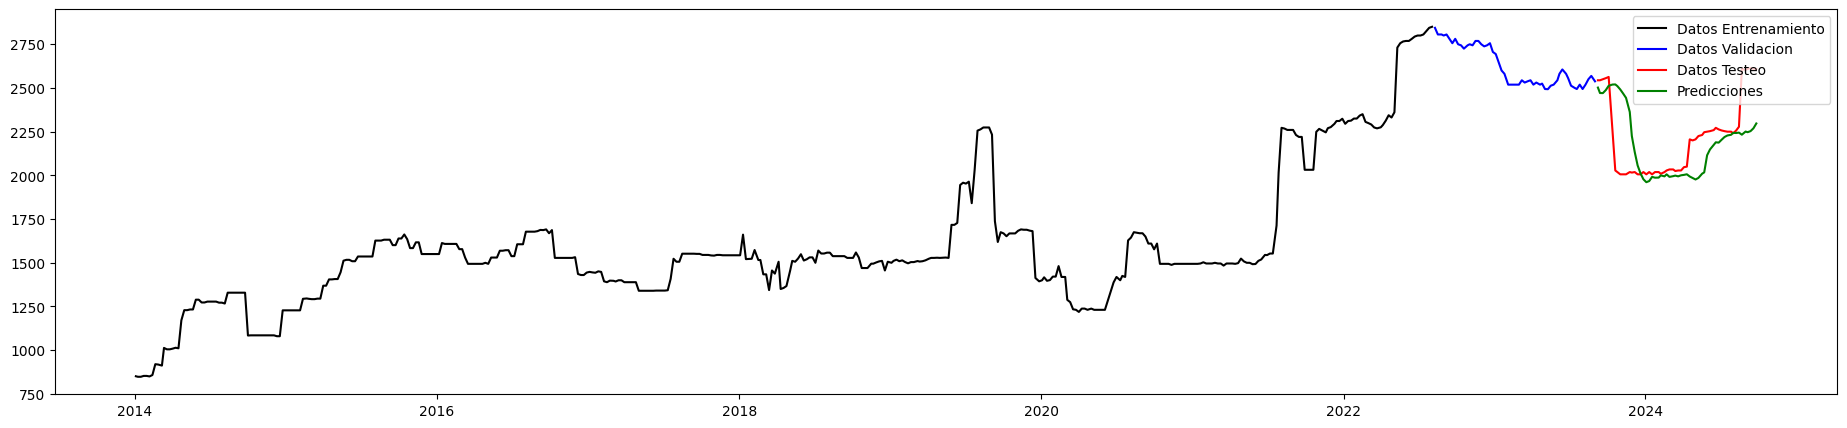

In [48]:

fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.PROMEDIO,color='red',label = 'Datos Testeo')
#ax.plot(datos_validacion.index,validacion,color='orange',label = 'Datos Testeo')
ax.plot(datos_testeo.index,testeo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

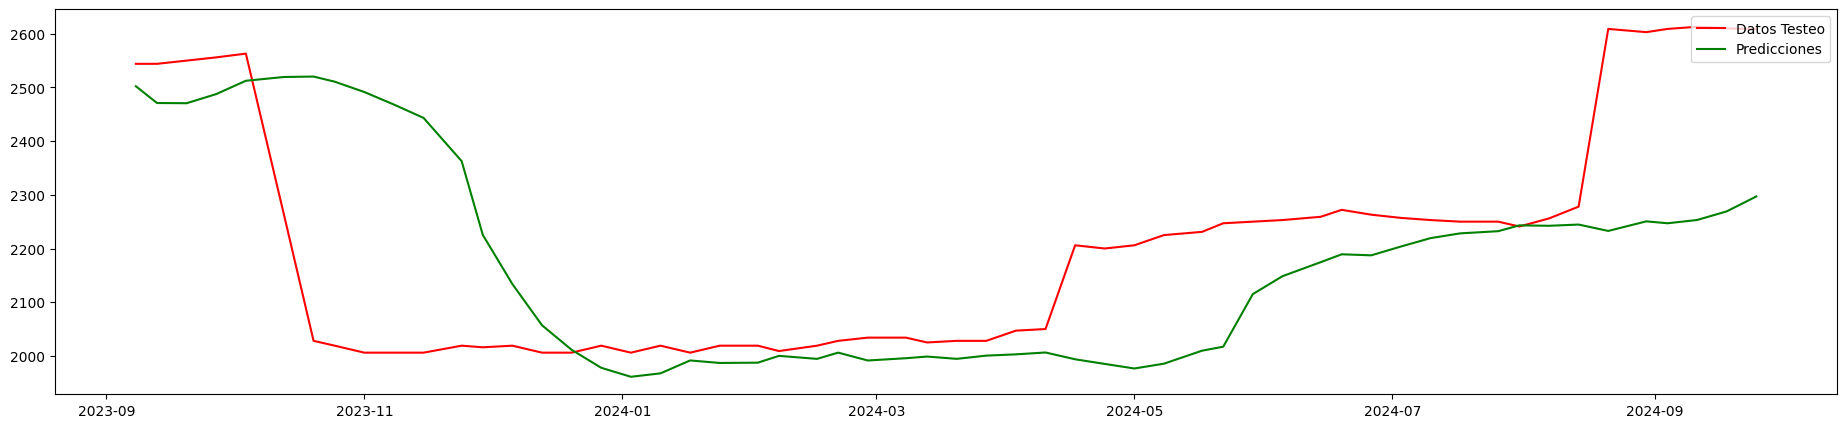

In [49]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo.index,datos_testeo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,testeo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [50]:
validacion =pd.DataFrame(validacion,index=datos_validacion.index[1:],columns=['Precio_Cierre'])
testeo = pd.DataFrame(testeo,index=datos_testeo.index,columns=['Precio_Cierre'])

In [52]:
#validacion.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Predicciones/EMD/validacion_red_densa.csv",index=True)
#testeo.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Predicciones/EMD/testeo_red_densa.csv",index=True)
